# ADS 505: Final Project - Predicting Healthcare Cross-Selling

### Project Team Members (Team 6):
Minsu Kim<br>
Abanather Negusu<br>
Connie Chow<br>

### GitHub Link: https://github.com/ADS-505-Applied-Data-Sci-for-Business/HealthCareCrossSelling

### Table of Contents:
1. Problem Statement and Justification for Proposed Approach
2. Exploratory Data Analysis
3. Feature Engineering, Data Wrangling and Pre-Processing
4. Feature Selection
5. Dataset Splitting (Training, Testing, Validation Sets)
6. Model Selection, Performance Results, Final Model Selection
7. Next Steps/Recommendations

# 1. Problem Statement and Justification
### Context: 
Our client is an Insurance company that has provided Health Insurance to its customers.  This client wants to build a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.
### Purpose: 
Predict Health Insurance Owners' who will be interested in Vehicle Insurance<br><p>

### Data Setup

#### Import Required Libraries and Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
%matplotlib inline
%config InlineBackend.figure_format='retina'
from datetime import datetime
from scipy.stats.mstats import winsorize
import warnings
warnings.filterwarnings("ignore")

#### Load Training and Test Datasets

In [ ]:
train_df = pd.read_csv('https://raw.githubusercontent.com/connie-chow/datasets/main/train.csv', sep=',')
test_df = pd.read_csv('https://raw.githubusercontent.com/connie-chow/datasets/main/test.csv', sep=',')

#### Initial Data Summary

In [ ]:
test_df.head()

In [ ]:
train_df.head()

In [ ]:
test_df_ori = test_df.copy()

In [ ]:
train_df.shape

In [ ]:
print(train_df.dtypes)

In [ ]:
print(train_df.head(5))

#### Handle Missing Values

In [ ]:
# Checking for missing values
train_df.isna().sum()

#### Descriptive Statistics

In [ ]:
#Summary Statistic
train_df.describe()

# 2. Exploratory Data Analysis

Check distribution of data per column

In [ ]:
# Histograms to check the distribution of values of numeric columns
num_cols = ['Age', 'Annual_Premium', 'Vintage', 'Region_Code', 'Policy_Sales_Channel']
fig, ax = plt.subplots(1, 5, figsize=(30, 10))
train_df[num_cols].hist(bins=20, figsize=(10, 7), ax=ax)
plt.show()

Vehicle Age by Gender

In [ ]:
train_df.groupby(['Vehicle_Age', 'Gender'])['Gender'].count().unstack().plot(kind="bar", stacked=True)

Check Outliers

In [ ]:
sns.catplot(x="Response", y="Age", data=train_df, kind="box");

In [ ]:
sns.catplot(x="Response", y="Region_Code", data=train_df, kind="box");

In [ ]:
sns.catplot(x="Response", y="Policy_Sales_Channel", data=train_df, kind="box");

In [ ]:
sns.catplot(x="Response", y="Vintage", data=train_df, kind="box");

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data=train_df, x="Region_Code", 
             hue = "Response").set(title = "Histogram of Region Codes for Each Response")

In [ ]:
train_df['Previously_Insured'] = train_df.Previously_Insured.astype(str)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data=train_df, x="Previously_Insured", 
             hue = "Response").set(title = "Histogram of Previously Insured count for Each Response type")
# none of the previously insured had a response 1, meaning previously insured customers are NOT interested

In [ ]:
train_df.groupby(['Response', 'Gender'])['Gender'].count().unstack().plot(kind="bar", stacked=True)

In [ ]:
### We need to create some pair plot to see the relation between the features.
pairplot = train_df.drop(['id','Gender', 'Vehicle_Damage', 'Vehicle_Age', 'Driving_License', 'Region_Code','Policy_Sales_Channel','Previously_Insured' ], axis =1)

KeyboardInterrupt: 

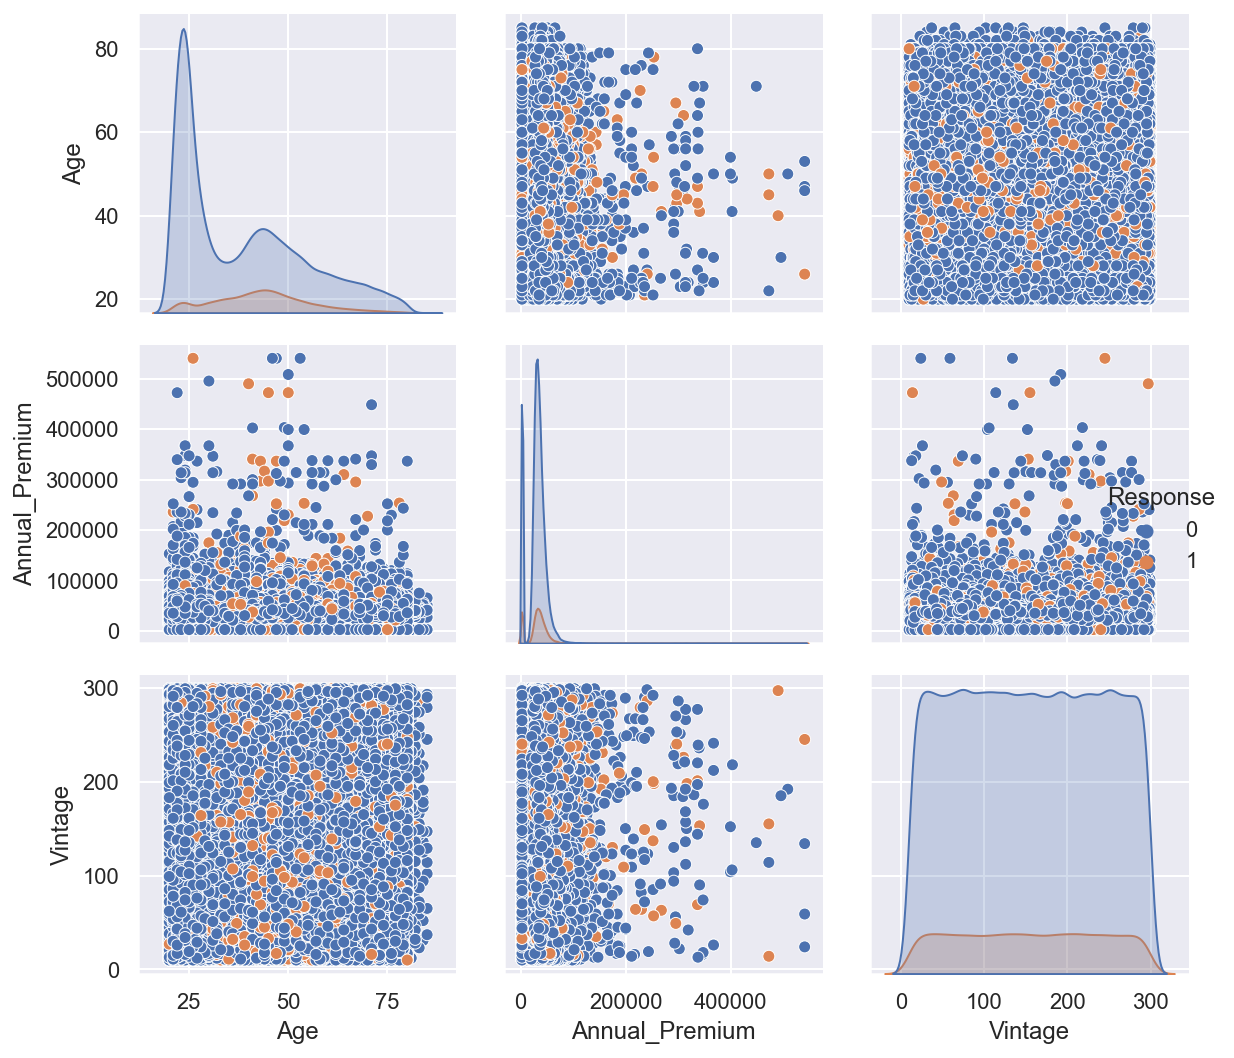

In [47]:
sns.pairplot(pairplot, hue ='Response')


#From the above graphs we can see that data is skewed, Before training the model we will correct the skewness using Preprocess

#### Normalized graphs showing response rate against categorical columns
Normalizing the bar charts makes it easier to compare the Response within categories.  For the first graph, Age column was plotted showing the positive response in orange (signs up for vehicle insurance) and negative response in blue (does not signup for vehicle insurance.  Clearly, with the normalization, we can see that customers in the Adult (age 35-55) range had the highest positive response rate.

In [ ]:
# For better visualization, three columns will be temporarily binned: Age, Region_Code, Vintage

# Bin 'Age' column categories: 0 to 35 = Young Adult, 36 to 55 = Adult, 56 to 99 = Senior
df_temp = train_df.copy()
df_temp['Age'] = pd.cut(df_temp['Age'], bins=[0,35,55,99],
                       labels=['Young Adult', 'Adult', 'Senior'])

# Bin 'Vintage' column - so it's the number of days the customer has been with the business
df_temp = df_temp.copy()
df_temp['Vintage'] = pd.cut(df_temp['Vintage'], bins=[0,91,183,274, 365],
                       labels=['3 Months+', '6 Months+', '9 Months+', '1 Year+'])

# Bin 'Region_Code' column - so it's the number of days the customer has been with the business
df_temp = df_temp.copy()
df_temp['Region_Code'] = pd.cut(df_temp['Region_Code'], bins=[0,15,30,45],
                       labels=['Region1', 'Region2', 'Region3'])

# Define grid for dataframe plots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (30, 30))
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.5,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.5)

crosstab_01 = pd.crosstab(df_temp['Age'], df_temp['Response'])
crosstab_norm = crosstab_01.div(crosstab_01.sum(1), axis = 0)
ax = crosstab_norm.plot(kind='bar', stacked = True, ax=axes[0,0])
ax.legend(["Reject", "Accept"])

crosstab_01 = pd.crosstab(df_temp['Vehicle_Age'], df_temp['Response'])
crosstab_norm = crosstab_01.div(crosstab_01.sum(1), axis = 0)
crosstab_norm.plot(kind='bar', stacked = True, ax=axes[0,1])
ax.legend(["Reject", "Accept"])

crosstab_01 = pd.crosstab(df_temp['Gender'], df_temp['Response'])
crosstab_norm = crosstab_01.div(crosstab_01.sum(1), axis = 0)
crosstab_norm.plot(kind='bar', stacked = True, ax=axes[0,2])
ax.legend(["Reject", "Accept"])

crosstab_01 = pd.crosstab(df_temp['Driving_License'], df_temp['Response'])
crosstab_norm = crosstab_01.div(crosstab_01.sum(1), axis = 0)
crosstab_norm.plot(kind='bar', stacked = True, ax=axes[1,0])
ax.legend(["Reject", "Accept"])

crosstab_01 = pd.crosstab(df_temp['Previously_Insured'], df_temp['Response'])
crosstab_norm = crosstab_01.div(crosstab_01.sum(1), axis = 0)
crosstab_norm.plot(kind='bar', stacked = True, ax=axes[1,1])
ax.legend(["Reject", "Accept"])

crosstab_01 = pd.crosstab(df_temp['Vehicle_Damage'], df_temp['Response'])
crosstab_norm = crosstab_01.div(crosstab_01.sum(1), axis = 0)
crosstab_norm.plot(kind='bar', stacked = True, ax=axes[1,2])
ax.legend(["Reject", "Accept"])

crosstab_01 = pd.crosstab(df_temp['Vintage'], df_temp['Response'])
crosstab_norm = crosstab_01.div(crosstab_01.sum(1), axis = 0)
crosstab_norm.plot(kind='bar', stacked = True, ax=axes[2,0])
ax.legend(["Reject", "Accept"])

crosstab_01 = pd.crosstab(df_temp['Region_Code'], df_temp['Response'])
crosstab_norm = crosstab_01.div(crosstab_01.sum(1), axis = 0)
crosstab_norm.plot(kind='bar', stacked = True, ax=axes[2,1])
ax.legend(["Reject", "Accept"])

In [ ]:
sns.displot(train_df, x="Age")
plt.title("Histogram Age")#title of graph
plt.show()#show graph

In [ ]:
#Checking Target varaible 
sns.countplot(train_df.Response)
plt.title("Response classes")#title of graph
plt.show()#show graph

In [ ]:
#Checking the count of  values in response
train_df.Response.value_counts()

There are higher people who whould be not be intrested compared to people that would. 

In [ ]:
#Checking gender count
sns.countplot(train_df.Gender)
train_df.Gender.value_counts()
plt.title("Gender Count")#title of graph
plt.show()#show graph

In [ ]:
sns.distplot(train_df[train_df.Response==0]['Age'], label='0')
sns.distplot(train_df[train_df.Response==1]['Age'], label='1')
plt.legend()
plt.title("Histograme of age groupby response")#title of graph
plt.show()#show graph

In [ ]:
#Checking  Driving_License count
sns.countplot(train_df.Driving_License)
train_df.Driving_License.value_counts()
plt.title("Driving license")#title of graph
plt.show()#show graph

So when I ran this looks like everyone has a driver license BUT take a look at the count of numbers that do not have license 
its 812. I wonder if people will say yes or no based on having a license.

In [ ]:
#Checking  Vehicle_Damage count
sns.countplot(train_df.Vehicle_Damage)
train_df.Vehicle_Damage.value_counts()
plt.title("Vehicle Damage count")#title of graph
plt.show()#show graph

In [ ]:
# plotting two histograms on the same axis
plt.hist(train_df['Response'], bins=25, alpha=0.45, color='red')
plt.hist(train_df['Age'], bins=25, alpha=0.45, color='blue')
  
plt.title("histogram with multiple \
variables (overlapping histogram)")
  
plt.legend(['Response', 
            'Age'])
  
plt.show()

No columns showed high correlation.  Age and Policy Sales Channel showed high opposite correlation.

In [ ]:
plt.figure(figsize=(20, 12))
sns.heatmap(train_df.corr(), annot=True)
plt.title("Correlation matrix")#title of graph
plt.show()#show graph

#### Correlation of Variables to Target
Age has the highest correlation which confirms the earliest chart when we plotted Age distribution against response distribution.  Ages 35-55 had the highest correlation to a positive response.  Next highest correlation is the Annual Premium and then Region Code.  It could be the case that customers residing in a certain region preferred to buy their healthcare insurer's vehicle insurance, maybe they were happy with the company or did not want to bother looking elsewhere.

In [48]:
print(train_df.corr()['Response'].sort_values(ascending=False))

Response                1.000000
Age                     0.111147
Annual_Premium          0.022575
Region_Code             0.010570
Driving_License         0.010155
Vintage                -0.001050
id                     -0.001368
Policy_Sales_Channel   -0.139042
Name: Response, dtype: float64


# 3. Feature Engineering, Data Wrangling and Pre-Processing

In [49]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [50]:
train_df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


We have labeled the columns of vehicle damage to 1 and 0. 1 represents vehicle damage and 0 represents no damage.

In [51]:
train_df['Vehicle_Damage'] = np.where(train_df['Vehicle_Damage']=='Yes', 1, 0)
test_df['Vehicle_Damage'] = np.where(test_df['Vehicle_Damage']=='Yes', 1, 0)

We have created buckets for vehicle age and labled it, if a vehicle age is less then 1 year = 1. And if the vehicle age is between 1 and 2 year = 2. And if the vehicle age is greather then 2 = 3.

In [52]:
col         = 'Vehicle_Age'
conditions  = [train_df[col] == '< 1 Year', train_df[col] == '1-2 Year', train_df[col] == '> 2 Years']
choices     = [1, 2, 3]
train_df['Vehicle_Age'] = np.select(conditions, choices, default=0)

conditions  = [test_df[col] == '< 1 Year', test_df[col] == '1-2 Year', test_df[col] == '> 2 Years']   
test_df['Vehicle_Age'] = np.select(conditions, choices, default=0)

In [53]:
# Save temporary df before scaling, use this for RandomForestClassifier
df_rfc_temp = train_df
print(df_rfc_temp.head(5))

   id  Gender  Age  Driving_License  Region_Code Previously_Insured  \
0   1    Male   44                1         28.0                  0   
1   2    Male   76                1          3.0                  0   
2   3    Male   47                1         28.0                  0   
3   4    Male   21                1         11.0                  1   
4   5  Female   29                1         41.0                  1   

   Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0            3               1         40454.0                  26.0      217   
1            2               0         33536.0                  26.0      183   
2            3               1         38294.0                  26.0       27   
3            1               0         28619.0                 152.0      203   
4            1               0         27496.0                 152.0       39   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0  


Below we're resizeing the distribution of values for thesse columns 'Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'. So that our mean of the observed values will be zero. 

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']:
    train_df[col] =  scaler.fit_transform(np.array(train_df[col]).reshape(-1, 1))
    test_df[col] =  scaler.transform(np.array(test_df[col]).reshape(-1, 1))

Handling Skewnessand tranforming outliers & resampling 

<AxesSubplot:xlabel='Annual_Premium'>

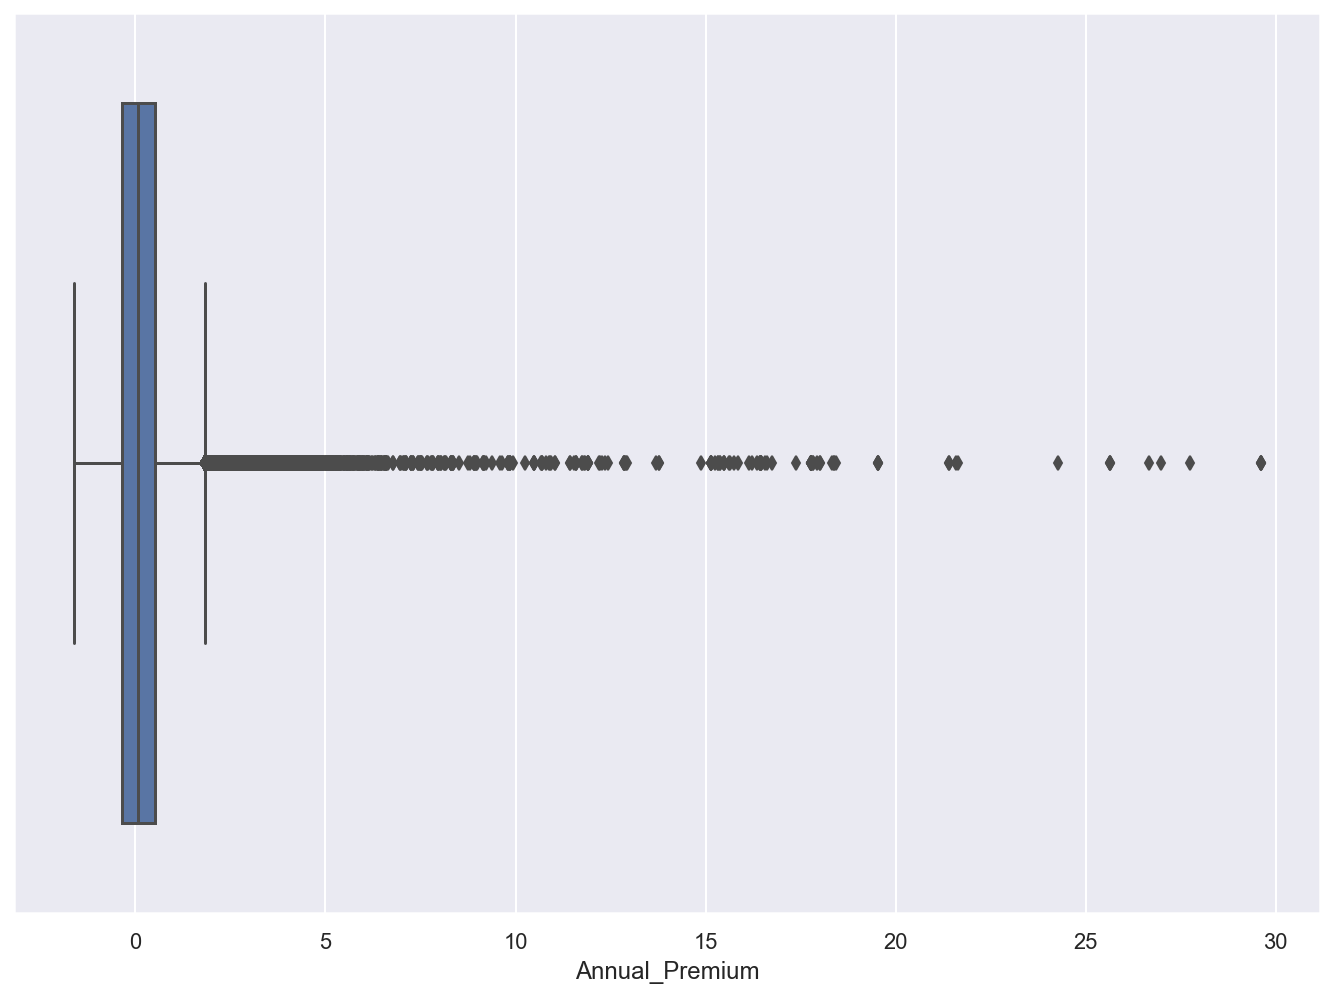

In [55]:
sns.boxplot(train_df['Annual_Premium'])

<AxesSubplot:xlabel='Annual_Premium'>

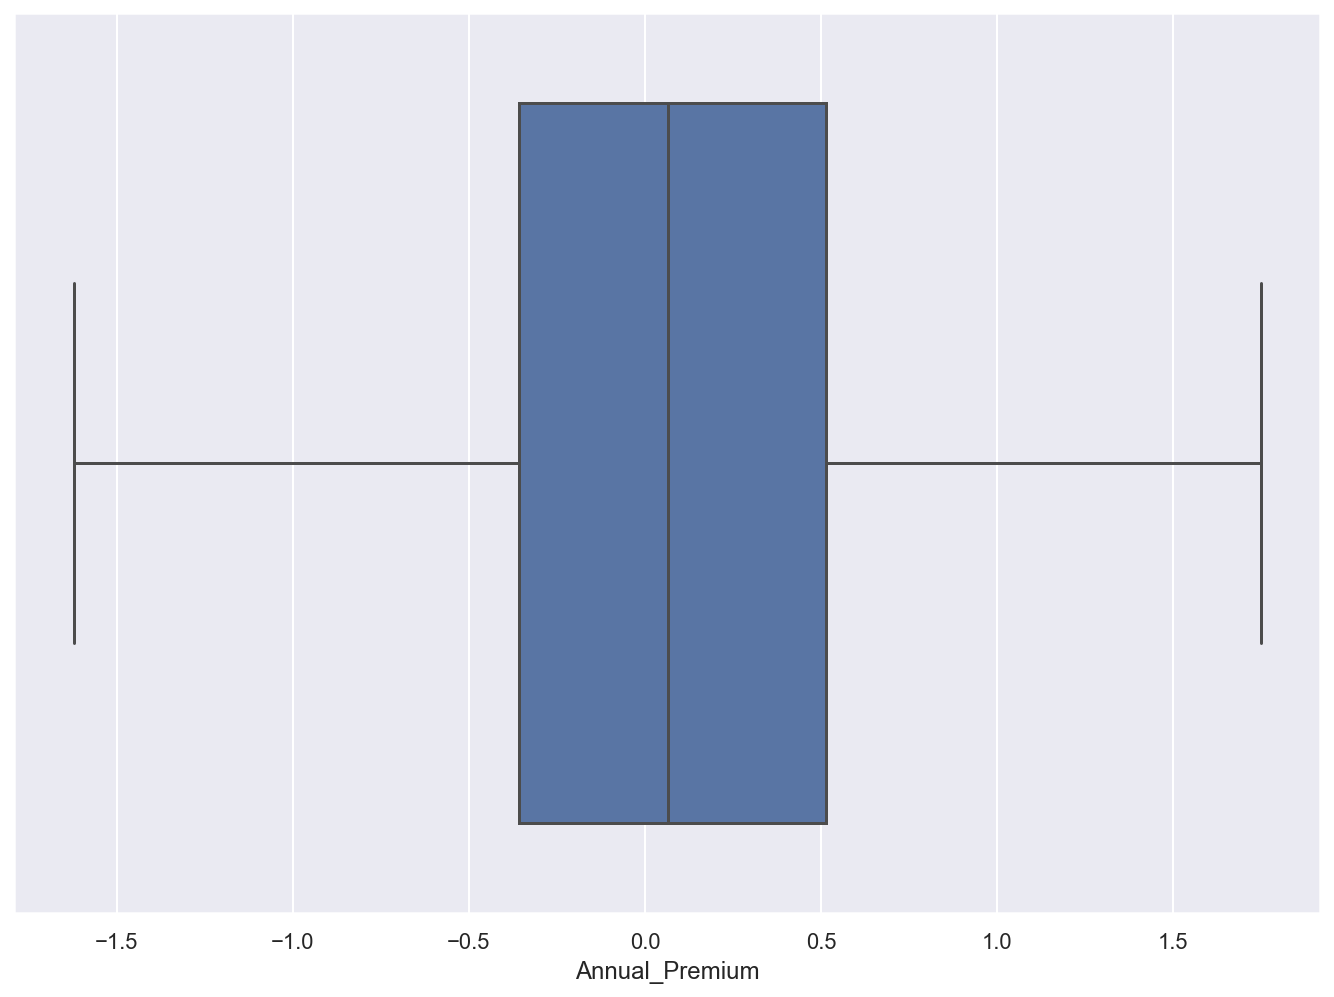

In [56]:
train_df['Annual_Premium'] = winsorize(train_df['Annual_Premium'], (0.01, 0.03))
test_df['Annual_Premium'] = winsorize(test_df['Annual_Premium'], (0.01, 0.03))

sns.boxplot(train_df['Annual_Premium'])

<AxesSubplot:>

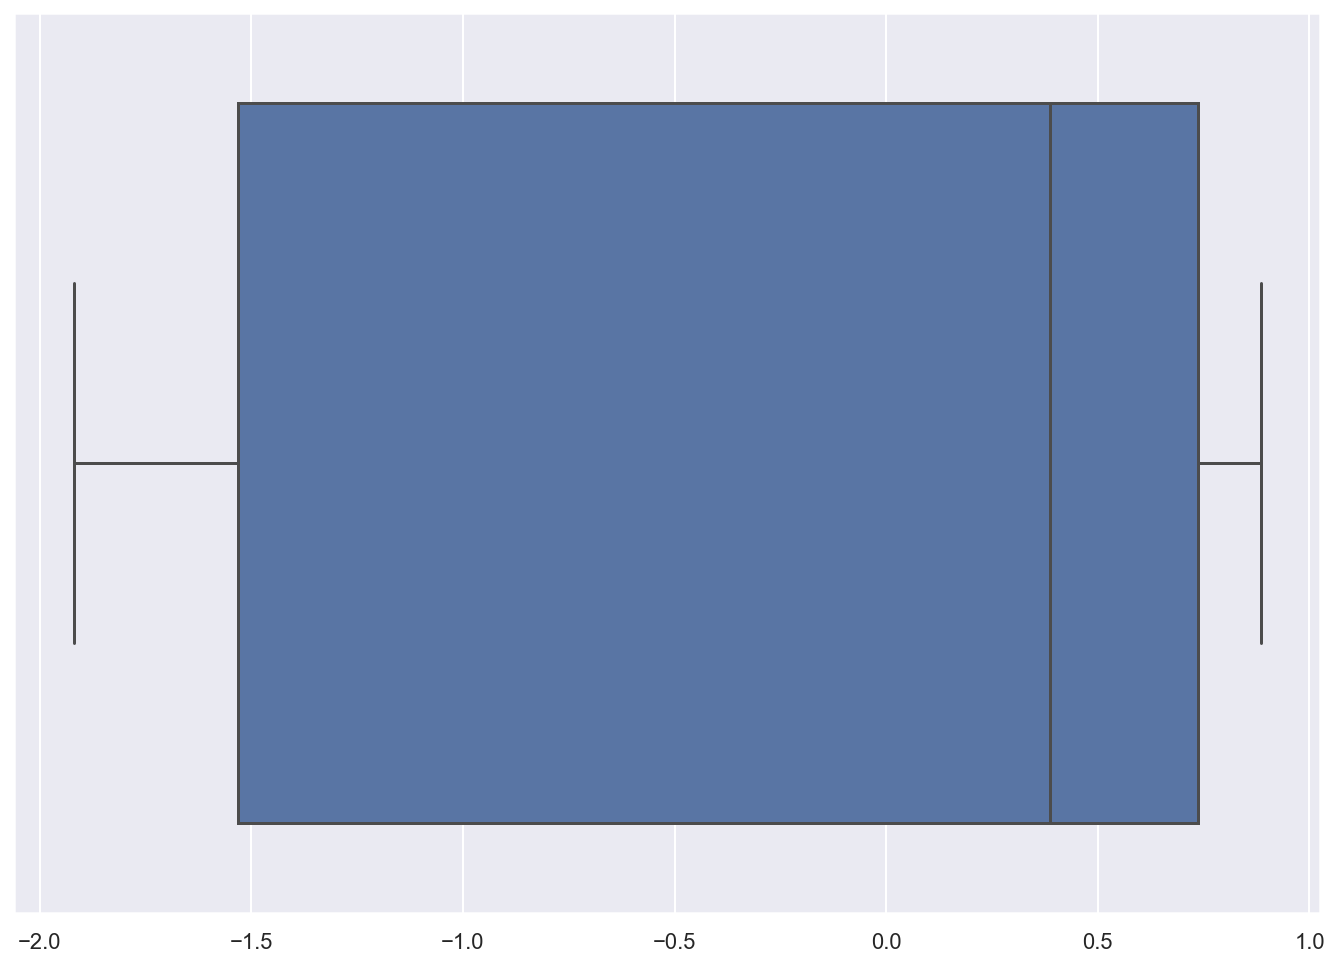

In [57]:
sns.boxplot(winsorize(train_df['Policy_Sales_Channel'], (0.01, 0.01)))

In [58]:
train_df['Policy_Sales_Channel'] = winsorize(train_df['Policy_Sales_Channel'], (0.01, 0.01))
test_df['Policy_Sales_Channel'] = winsorize(test_df['Policy_Sales_Channel'], (0.01, 0.01))

<AxesSubplot:>

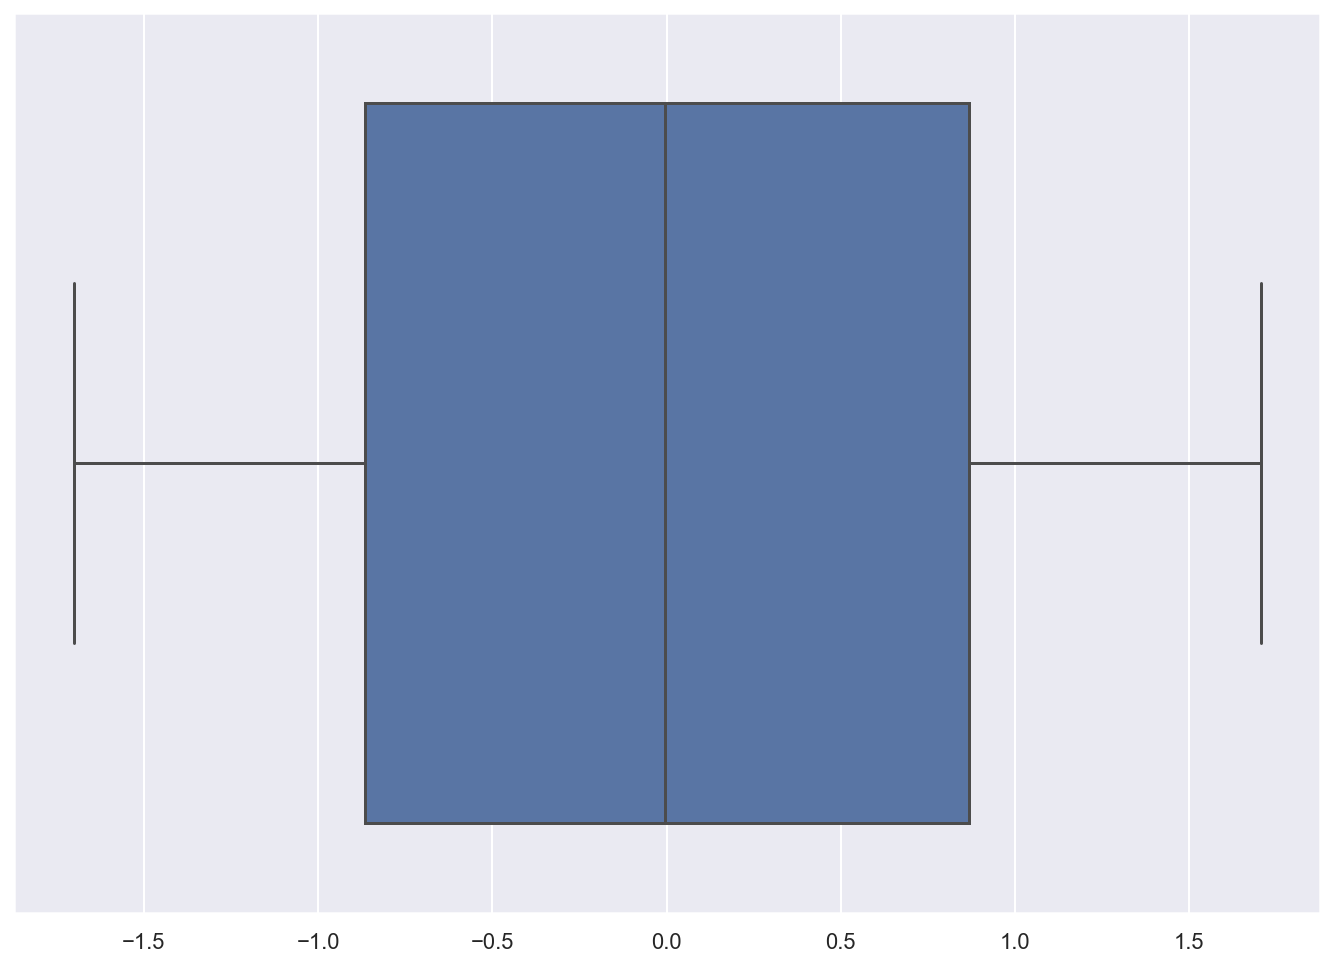

In [59]:
sns.boxplot(winsorize(train_df['Vintage'], (0.01, 0.01)))

In [60]:
train_df['Vintage'] = winsorize(train_df['Vintage'], (0.01, 0.01))
test_df['Vintage'] = winsorize(test_df['Vintage'], (0.01, 0.01))

# 4. Feature Selection
We conduct feature selection to optimize the Random Forest Classifier.  Features selection includes several separate, but comprehensive approach, see below.

#### Drop highly correlated features
Conducted pairwise correlation to find features that are redundant.  Ones that are highly correlated to each other do not provide the model with any extra information so we only keep one of those features.  Vehicle_Age and Age are highly correlated to the probability that a customer will signup for vehicle insurance.  Ages 35-55 were most likely to signup for the cross-selling offer, maybe because this age group is busy with families and are happy with the current healthcare insurance provider and don't have time to research or look around for vehicle insurance.  With a cutoff of 0.3, there are no highly correlated pairs.

In [61]:
# Use Label Encoder to encode the Vehicle_Age because there are 3 categorical values which are ordinal in nature
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df_train_rfc = train_df
df_train_rfc['Vehicle_Age'] = le.fit_transform(df_train_rfc['Vehicle_Age'])

# one hot encode the Gender column because it contains Female or Male string values
df_ohed = pd.get_dummies(df_train_rfc, columns = ['Gender'])

In [62]:
corr_matrix = df_ohed.corr()
matrix = corr_matrix["Response"].sort_values(ascending=False)
matrix = matrix[abs(matrix) >= 0]

print("Features Correlated to Target - Ranked Highest to Lowest")
print(matrix)

print()
print("Pairwise Correlation - Determine Features That Are Highly Correlated - Cutoff at 0.3")
# Indexing with numbers on a numpy matrix will probably be faster
corr = corr_matrix.values
rows, cols = corr.shape

for i in range(cols):
    for j in range(i + 1, cols):
        if corr[i, j] > 0.3:
            print(corr_matrix.columns[i] + ', ' + corr_matrix.index[j] + ': ' + str(corr[i, j]))

Features Correlated to Target - Ranked Highest to Lowest
Response                1.000000
Vehicle_Damage          0.354400
Vehicle_Age             0.221874
Age                     0.111147
Gender_Male             0.052440
Annual_Premium          0.021957
Region_Code             0.010570
Driving_License         0.010155
Vintage                -0.001055
id                     -0.001368
Gender_Female          -0.052440
Policy_Sales_Channel   -0.139520
Name: Response, dtype: float64

Pairwise Correlation - Determine Features That Are Highly Correlated - Cutoff at 0.3
Age, Vehicle_Age: 0.7657901010871334
Vehicle_Age, Vehicle_Damage: 0.3968729148107117
Vehicle_Damage, Response: 0.35439954387975825


#### Drop Columns Low Information Features:
Drop columns with low variance.  The Driving_License column has more than 95% values of 1 and not 0.  Thus feeding this column to the model will not provide it with any useful information as to making a prediction.  Also, the id column is just an identifier for each customer, there is no learning to be made from this column so we drop it as well.

In [63]:
df_ohed = df_ohed.drop(columns=['Driving_License'])
df_ohed = df_ohed.drop(columns=['id'])

#### Recursive Feature Elimination
Method was employed to select features in addition to the correlation to target method.  Age is the top feature to use which makes sense because our EDA chart showed that ages 35-55 had a high response rate.  Region Code may also be top because most people are in a certain region code and maybe people in that geographic area are of a certain suburb/neighborhood with families and don't have time to research vehicle insurance companies.  If they are happy with thier current healthcare insurance provider then when cross-selled to they just accept the offer and signup.  Customers who were previously insured tended to accept the cross-selling offer.  This would make sense because that means they can afford vehicle insurance and maybe the company made a better offer to them.  Also, people who have experienced vehicle damage before (assuming they've been in an accident) probably are very likely to want to be insured to avoid out-of-pocket costs, so when approached with a better rate they are likely to signup especially if they have already established trust with their current healthcare insurance provider.

In [64]:
# Select 10 features and print out in order of ranking
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from operator import itemgetter

regressor = RandomForestRegressor(n_estimators=100, max_depth=10)
n_features_to_select = 10
rfe = RFE(regressor, n_features_to_select=n_features_to_select)

X = df_ohed.drop(columns=['Response'])
y = df_ohed['Response']
rfe.fit(X, y)

# print out features selected in order of ranking
features = X.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 Age
1 Region_Code
1 Previously_Insured
1 Vehicle_Age
1 Vehicle_Damage
1 Annual_Premium
1 Policy_Sales_Channel
1 Vintage
1 Gender_Female
1 Gender_Male


Vehicle Age, and both Genders were not listed as a top feature from RFE, so we drop them.

In [65]:
df_ohed = df_ohed.drop(columns=['Gender_Male', 'Gender_Female'])
#print(df_ohed.head(5))

#### Random Forest Feature Importances
The outcomes confirm what we see with Recursive Feature Elimination

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 0, n_estimators = 100)

df_rfc_temp = pd.get_dummies(df_rfc_temp, columns= ['Gender'])
X_rfc = df_rfc_temp.drop(columns=['Response'])
y_rfc = df_rfc_temp['Response']

model = rfc.fit(X_rfc, y_rfc)

# Plot the top features based on its importance and most important feature on top
(pd.Series(model.feature_importances_, index = X_rfc.columns)
   .nlargest(47)  
   .plot(kind='barh', figsize = [10,7])
   .invert_yaxis()) 

plt.yticks(size = 15)
plt.title('Top Features derived by Random Forest', size = 20)

# 5. Dataset Splitting

#### Setup the dataset for train_test_split

In [66]:
train_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

In [67]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['Gender'] = le.fit_transform(train_df['Gender'])
test_df['Gender'] = le.transform(test_df['Gender'])

In [68]:
train_df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0.333777,1,0.121784,0,2,1,0.574539,-1.587234,0.748795,1
1,1,2.396751,1,-1.767879,0,1,0,0.172636,-1.587234,0.342443,0
2,1,0.527181,1,0.121784,0,2,1,0.449053,-1.587234,-1.521998,1
3,1,-1.148985,1,-1.163187,1,0,0,-0.113018,0.737321,0.581474,0
4,0,-0.633242,1,1.104409,1,0,0,-0.178259,0.737321,-1.378580,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,1,2.267815,1,-0.029389,1,1,0,-0.022912,-1.587234,-0.792954,0
381105,1,-0.568774,1,0.802063,1,0,0,0.549093,0.737321,-0.279037,0
381106,1,-1.148985,1,0.272958,1,0,0,0.264543,0.884912,0.079509,0
381107,0,1.881007,1,-0.936427,0,2,1,0.816389,0.220753,-0.960275,0


In [69]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, plot_confusion_matrix

In [70]:
y = train_df['Response']#get y
X = train_df.drop('Response', axis=1)#get x

In [71]:
X_test = test_df

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 19)#split dataset to train and val

### Process imbalanced data with SMOTE

In [73]:
# !pip install imbalanced-learn==0.6.0
# !pip install scikit-learn==0.22.1

We will use SMOTE to generate new data based on original data to solve imbalanced dataset problem. <br>
SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b

In [74]:
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import GridSearchCV
#smote to process imbalance dataset

sm = SMOTE() 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# 6. Model Selection

### Hypertuning: Find best parameters

We will use GridSearchCV to find best parameters for each model.

#### Stochastic Gradient Descent

In [64]:
parameters = {'penalty':('l1', 'l2'), 'max_iter':[500, 1000]}
linear_classifier = GridSearchCV(SGDClassifier(), parameters) #finetune to find best parameters
linear_classifier.fit(X_train_res, y_train_res)

GridSearchCV(estimator=SGDClassifier(),
             param_grid={'max_iter': [500, 1000], 'penalty': ('l1', 'l2')})

In [65]:
linear_classifier.best_params_ #best parameters

{'max_iter': 1000, 'penalty': 'l1'}

In [66]:
linear_classifier.best_score_ #best score

0.7847022650655233

#### Logistic Regression

In [67]:
logit_reg = LogisticRegression(random_state=42)

In [68]:
# defining gridesearch result viewer

def gridsearch_df_viewer(gridsearch__cv_results_):
  # search.cv_results_
  to_drop = ['mean_fit_time',
            'std_fit_time',
            'mean_score_time',
            'std_score_time',
            'split0_test_score', 
            'split1_test_score',
            'split2_test_score', 
            'split3_test_score', 
            'split4_test_score']

  df = pd.DataFrame(gridsearch__cv_results_)
  df = df.drop(columns=to_drop)
  df = df.sort_values('rank_test_score')
  df = df.reset_index()
  return df.head(5)

In [69]:
# Gridsearch to find best parameters for logistic regression using f1 weighted score as measure
params={'penalty':['l2'],
        'C':[0.1,1,10],
        'solver':['newton-cg', 'lbfgs','liblinear']}

search = GridSearchCV(logit_reg, params, scoring='f1_weighted', n_jobs=-1)
search.fit(X_train_res, y_train_res)

gridsearch_df_viewer(search.cv_results_)

,index,param_C,param_penalty,param_solver,params,mean_test_score,std_test_score,rank_test_score
0,2,0.1,l2,liblinear,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.776121,0.000425,1
1,1,0.1,l2,lbfgs,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.776074,0.000404,2
2,0,0.1,l2,newton-cg,"{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-...",0.776072,0.000407,3
3,5,1,l2,liblinear,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.776053,0.000403,4
4,3,1,l2,newton-cg,"{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}",0.776046,0.000420,5


In [70]:
logit_reg = LogisticRegression(random_state=42, penalty='l2', solver='liblinear', C=0.1)

In [71]:
logit_reg.fit(X_train_res, y_train_res)

logit_reg.score(X_val, y_val)

0.6380178950959041

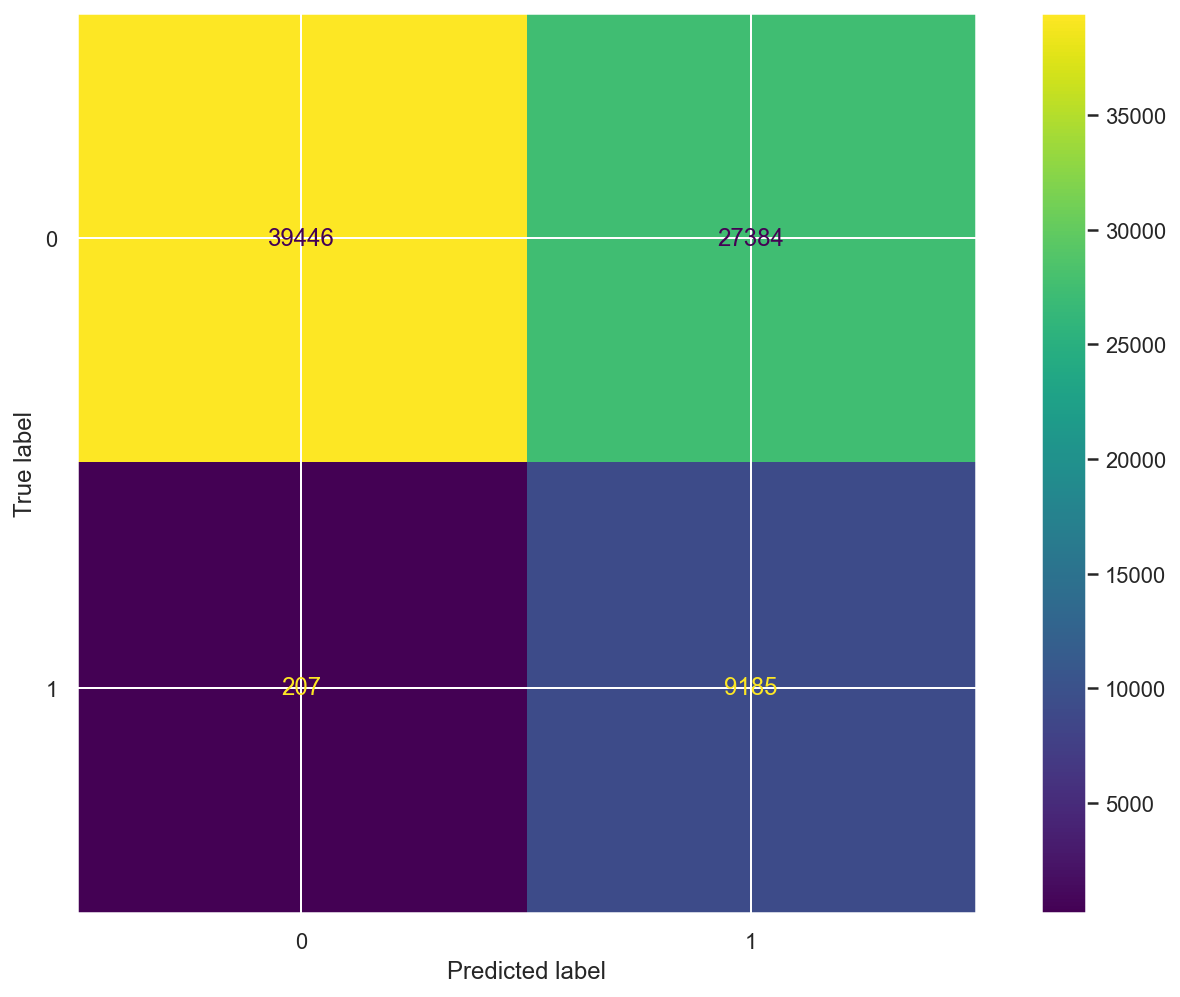

In [72]:
plot_confusion_matrix(logit_reg, X=X_val, y_true=y_val)

In [73]:
# F1 score for logistic regression

from sklearn.metrics import f1_score

lr_pred = logit_reg.predict(X_val)

f1_score(y_val, lr_pred, average='weighted')

0.6988456998788372

In [74]:
print(classification_report(lr_pred, y_val, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.59      0.99      0.74     39653
           1       0.98      0.25      0.40     36569

    accuracy                           0.64     76222
   macro avg       0.78      0.62      0.57     76222
weighted avg       0.78      0.64      0.58     76222



#### Random Forest

In [75]:
parameters = {'criterion':('gini', 'entropy'), 'n_estimators':[50, 100]}
forest_classifier = GridSearchCV(RandomForestClassifier(), parameters) #finetune to find best parameters
forest_classifier.fit(X_train_res, y_train_res)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'n_estimators': [50, 100]})

In [76]:
forest_classifier.best_params_ #best parameters

{'criterion': 'entropy', 'n_estimators': 100}

In [77]:
forest_classifier.best_score_ #best score

0.9136859130103401

The best parameters of random forest are criterion: gini, n_estimators=100 if we train this model with these parameters we will have 0.83 on accuracy, this is highest accuracy with best parameter of random forest

#### Decision Tree

In [78]:
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[7, 11]}
decisiontree_classifier = GridSearchCV(DecisionTreeClassifier(), parameters) #finetune to find best parameters
decisiontree_classifier.fit(X_train_res, y_train_res)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [7, 11]})

In [79]:
decisiontree_classifier.best_params_ #best parameters

{'criterion': 'gini', 'max_depth': 11}

In [80]:
decisiontree_classifier.best_score_ #best score

0.8304942267291523

The best parameters of decision tree are criterion: entropy, max depth=11 if we train this model with these parameters we will have 0.83 on accuracy, this is highest accuracy with best parameter of decision tree model

#### AdaBoost

In [81]:
parameters = {'n_estimators':[25, 50]}
ada_classifier = GridSearchCV(AdaBoostClassifier(), parameters) #finetune t find best parameters
ada_classifier.fit(X_train_res, y_train_res)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [25, 50]})

In [82]:
ada_classifier.best_params_ #best parameters

{'n_estimators': 50}

In [83]:
ada_classifier.best_score_ #best score

0.8128576448807318

The best parameters of adaboost is The maximum number of estimators is 50, if we train this model with this parameters we will have 0.81 on accuracy, this is highest accuracy with best parameter of adaboost model. <br>
=> This accuracy is lower than random forest model.

#### Neural Network

In [84]:
parameters = {'solver':('adam', 'sgd'), 'activation':('relu', 'tanh'), 
              'hidden_layer_sizes':[2, 4], 'max_iter': [200, 400]} 
nn = GridSearchCV(MLPClassifier(), parameters) #finetune t find best parameters
nn.fit(X_train_res, y_train_res)

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ('relu', 'tanh'),
                         'hidden_layer_sizes': [2, 4], 'max_iter': [200, 400],
                         'solver': ('adam', 'sgd')})

In [85]:
nn.best_params_ #best parameters

{'activation': 'tanh',
 'hidden_layer_sizes': 4,
 'max_iter': 200,
 'solver': 'adam'}

In [86]:
nn.best_score_ #best score

0.7954882686479061

The best parameters of neural network are: activation: tanh, we use 4 hidden layers and adam as optimization. The accuracy is 0.79, this is lowest accuracy of 6 models we trained.

In [112]:
forest_pred = forest_classifier.predict(X_val)#predict validation data
cm_forest = confusion_matrix(y_val, forest_pred) #traditional confusion matrix

linear_classifier_pred = linear_classifier.predict(X_val)#predict validation data
cm_linear = confusion_matrix(y_val, linear_classifier_pred) #traditional confusion matrix

decisiontree_classifier_pred = decisiontree_classifier.predict(X_val)#predict validation data
cm_tree = confusion_matrix(y_val, decisiontree_classifier_pred) #traditional confusion matrix

ada_pred = ada_classifier.predict(X_val)#predict validation data
cm_ada = confusion_matrix(y_val, ada_pred) #traditional confusion matrix

nn_pred = nn.predict(X_val)#predict validation data
cm_nn = confusion_matrix(y_val, nn_pred) #traditional confusion matrix

log_pred = logit_reg.predict(X_val)#predict validation data
cm_log = confusion_matrix(y_val, log_pred) #traditional confusion matrix

### ROC Curve: Compare the Models

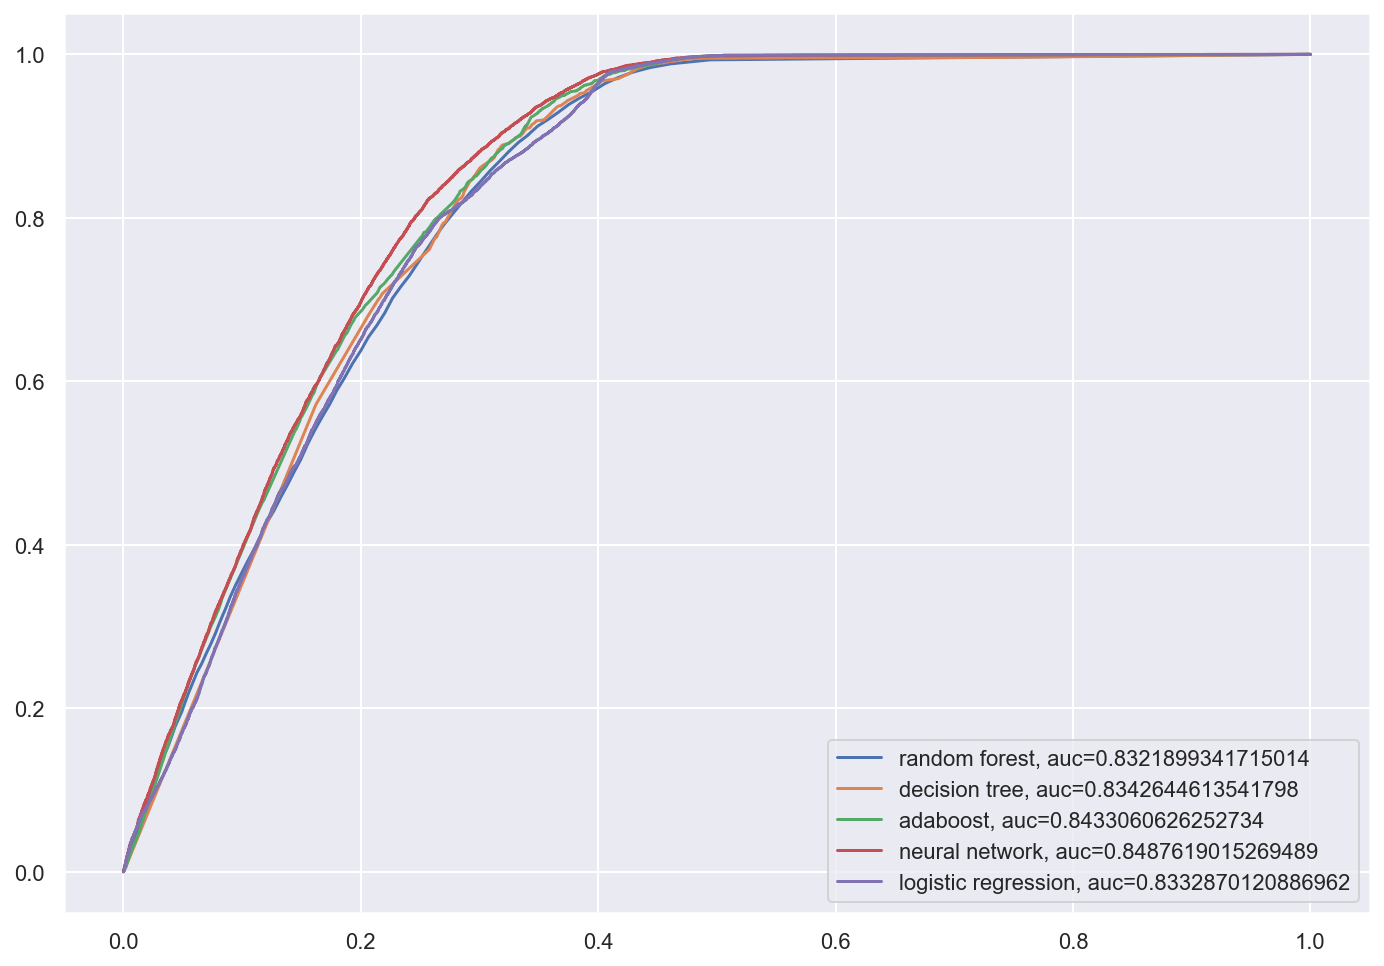

In [113]:
forest_pred_proba = forest_classifier.predict_proba(X_val)[::,1] #predict probabilities
fpr_forest, tpr_forest, _ = roc_curve(y_val,  forest_pred_proba) #calculate false positive and true positive
auc_forest = roc_auc_score(y_val, forest_pred_proba) #auc score

decisiontree_classifier_pred_proba = decisiontree_classifier.predict_proba(X_val)[::,1] #predict probabilities
fpr_tree, tpr_tree, _ = roc_curve(y_val,  decisiontree_classifier_pred_proba) #calculate false positive and true positive
auc_tree = roc_auc_score(y_val, decisiontree_classifier_pred_proba) #auc score

ada_pred_proba = ada_classifier.predict_proba(X_val)[::,1] #predict probabilities
fpr_ada, tpr_ada, _ = roc_curve(y_val,  ada_pred_proba) #calculate false positive and true positive
auc_ada = roc_auc_score(y_val, ada_pred_proba) #auc score

nn_pred_proba = nn.predict_proba(X_val)[::,1] #predict probabilities
fpr_nn, tpr_nn, _ = roc_curve(y_val,  nn_pred_proba) #calculate false positive and true positive
auc_nn = roc_auc_score(y_val, nn_pred_proba) #auc score

log_pred_proba = logit_reg.predict_proba(X_val)[::,1] #predict probabilities
fpr_log, tpr_log, _ = roc_curve(y_val,  log_pred_proba) #calculate false positive and true positive
auc_log = roc_auc_score(y_val, log_pred_proba) #auc score

plt.plot(fpr_forest,tpr_forest,label="random forest, auc="+str(auc_forest))
plt.plot(fpr_tree,tpr_tree,label="decision tree, auc="+str(auc_tree))
plt.plot(fpr_ada, tpr_ada,label="adaboost, auc="+str(auc_ada))
plt.plot(fpr_nn,tpr_nn,label="neural network, auc="+str(auc_nn))
plt.plot(fpr_log,tpr_log,label="logistic regression, auc="+str(auc_log))

plt.legend(loc=4)
plt.show()

### F1 score

In [114]:
#Evaluate f1 score each model on validation dataset
from sklearn.metrics import f1_score

print("F1 score of random forest model is: ", f1_score(y_val, forest_pred, average='weighted'))
print("F1 score of linear model is: ", f1_score(y_val, linear_classifier_pred, average='weighted'))
print("F1 score of decision tree model is: ", f1_score(y_val, decisiontree_classifier_pred, average='weighted'))
print("F1 score of adaboost model is: ", f1_score(y_val, ada_pred, average='weighted'))
print("F1 score of Neural network model is: ", f1_score(y_val, nn_pred, average='weighted'))
print("F1 score of Logistic Regression model is: ", f1_score(y_val, log_pred, average='weighted'))

F1 score of random forest model is:  0.8384743930962543
F1 score of linear model is:  0.6990151795874153
F1 score of decision tree model is:  0.7827333454731527
F1 score of adaboost model is:  0.7640040282016075
F1 score of Neural network model is:  0.7477511390129322
F1 score of Logistic Regression model is:  0.6988456998788372


#### => Random forest has highest F1 score, this is best model

### Confusion matrix

In [93]:
target_names = ['0','1'] #class name

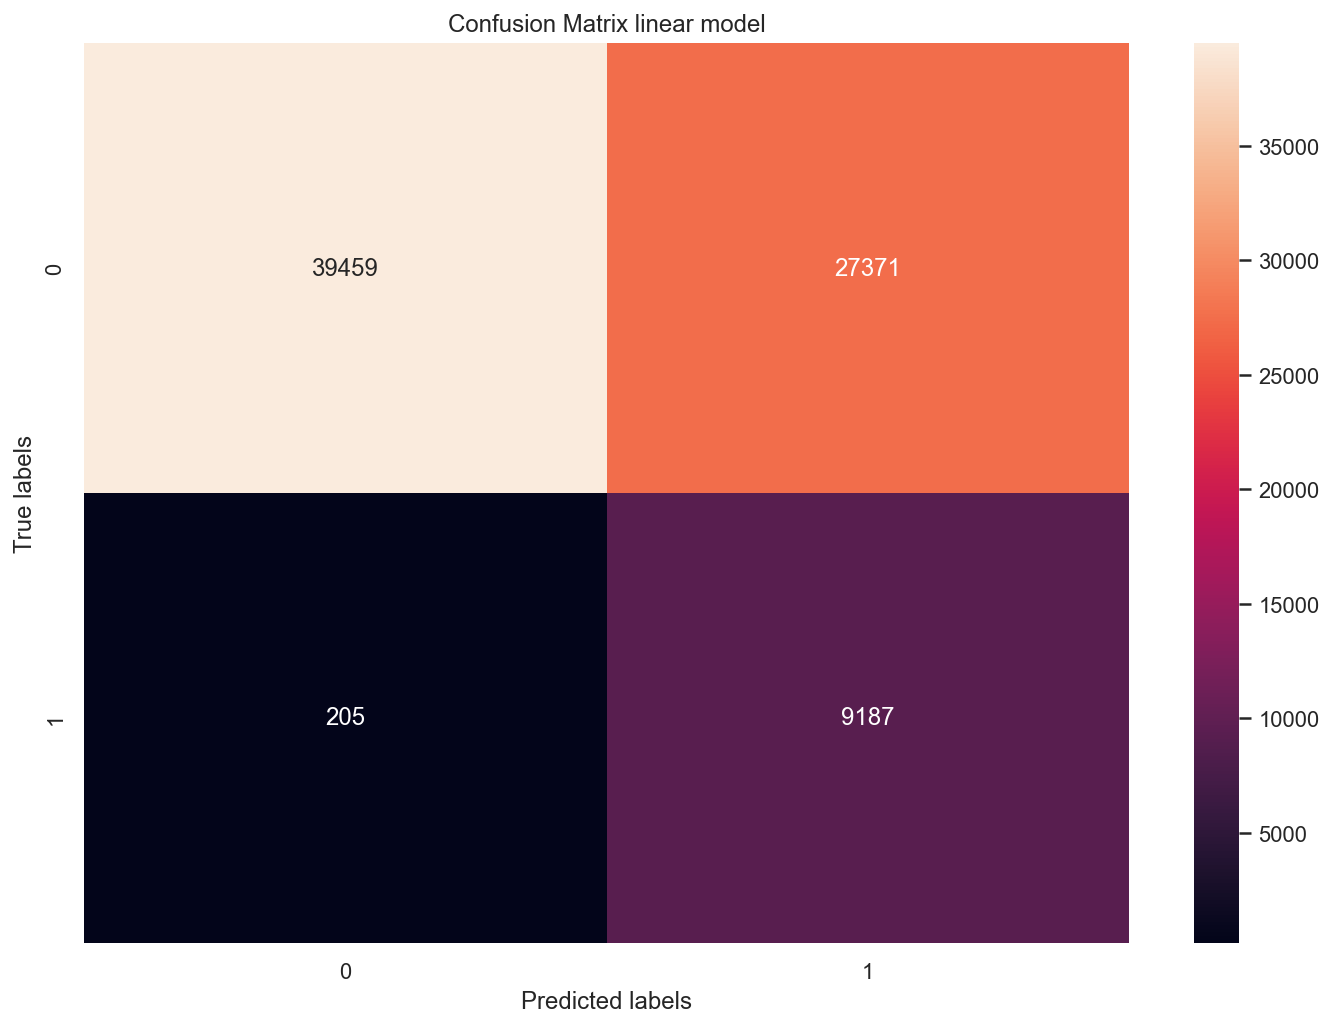

In [94]:
ax = plt.subplot()
sns.heatmap(cm_linear, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix linear model');
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);

The graph show 39459 class 0 predict true and 9187 class 1 predict true, we have about 0.6% class 0 predict wrong and 0.1% class 1 predict wrong, this result isn't good for class 0.

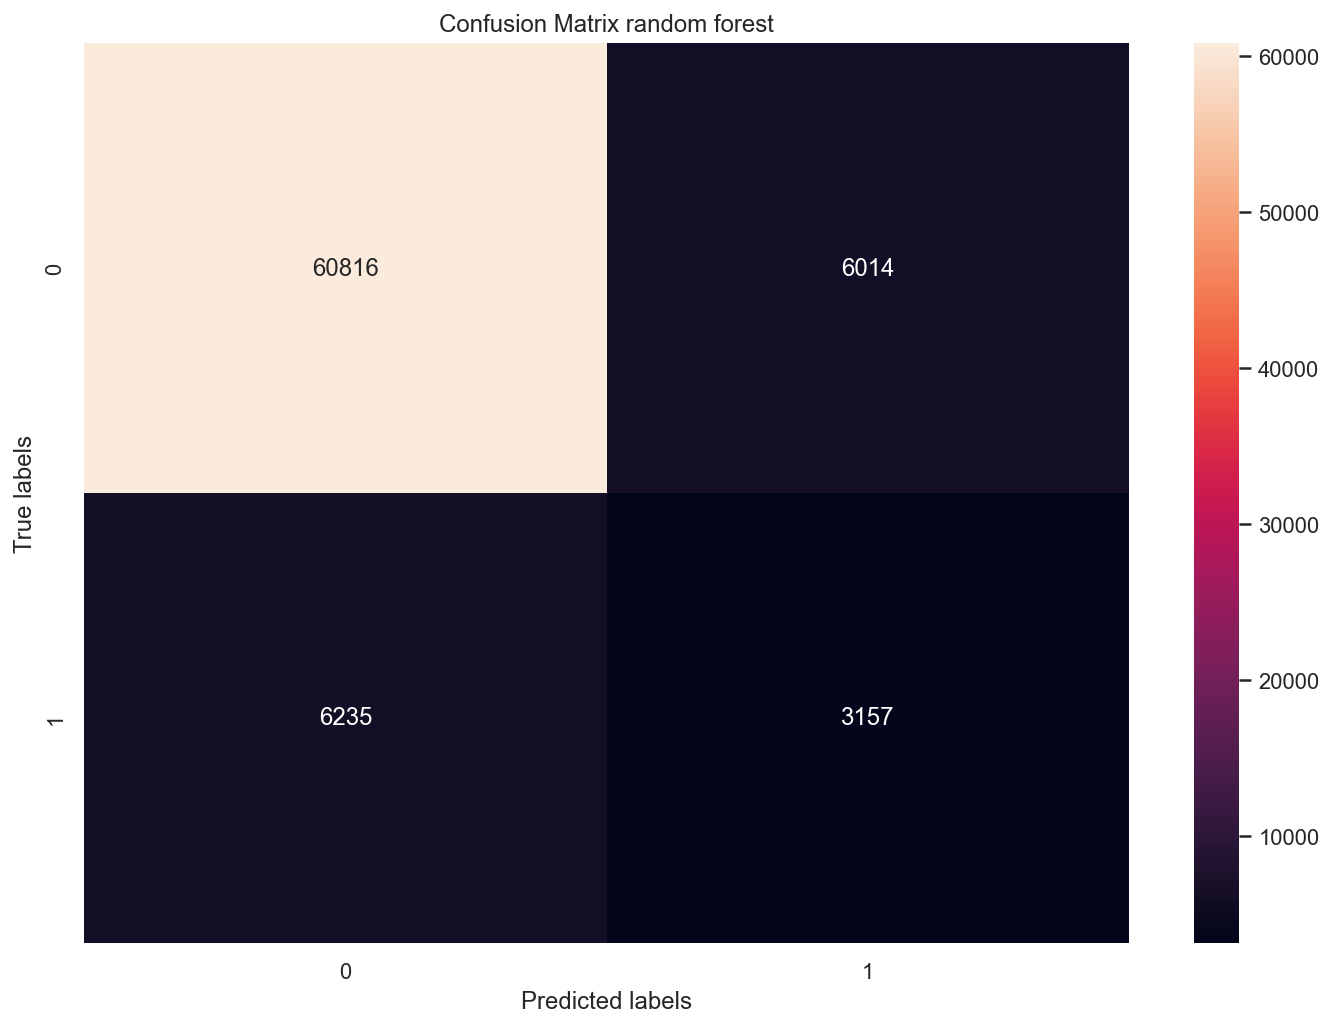

In [95]:
ax = plt.subplot()
sns.heatmap(cm_forest, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix random forest');
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);

The graph show 60816 class 0 predict true and 3157 class 1 predict true, we have about 0.1% class 0 predict wrong and 0.3% class 1 predict wrong, this result isn't good for class 1 but it's very good when predict class 0.

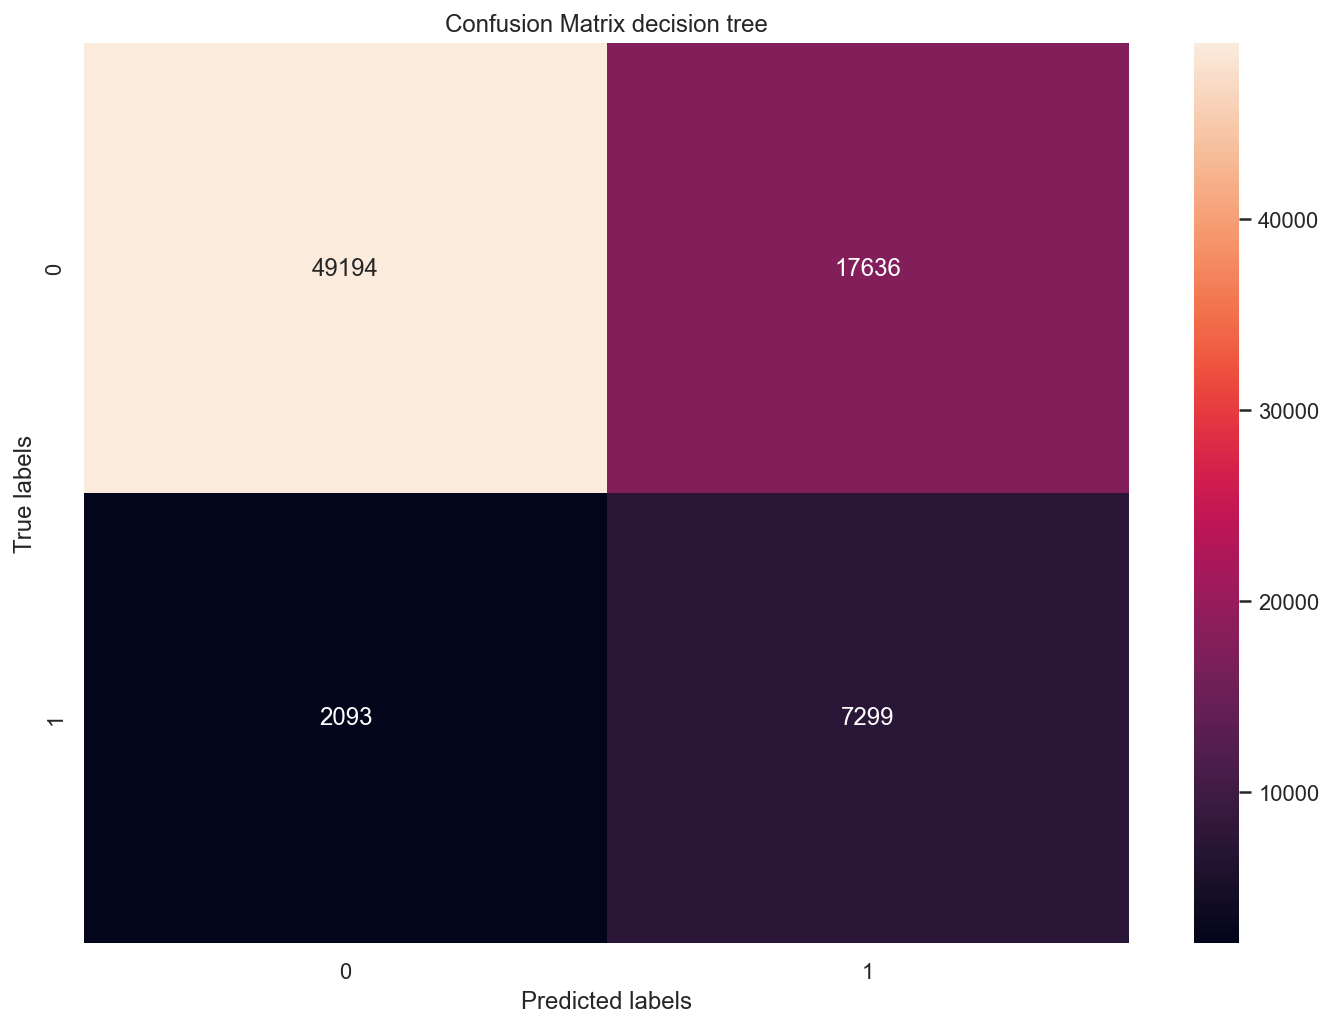

In [96]:
ax = plt.subplot()
sns.heatmap(cm_tree, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix decision tree');
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);

The graph show 49194 class 0 predict true and 7299 class 1 predict true, we have about 0.4% class 0 predict wrong and 0.2% class 1 predict wrong, this result is good.

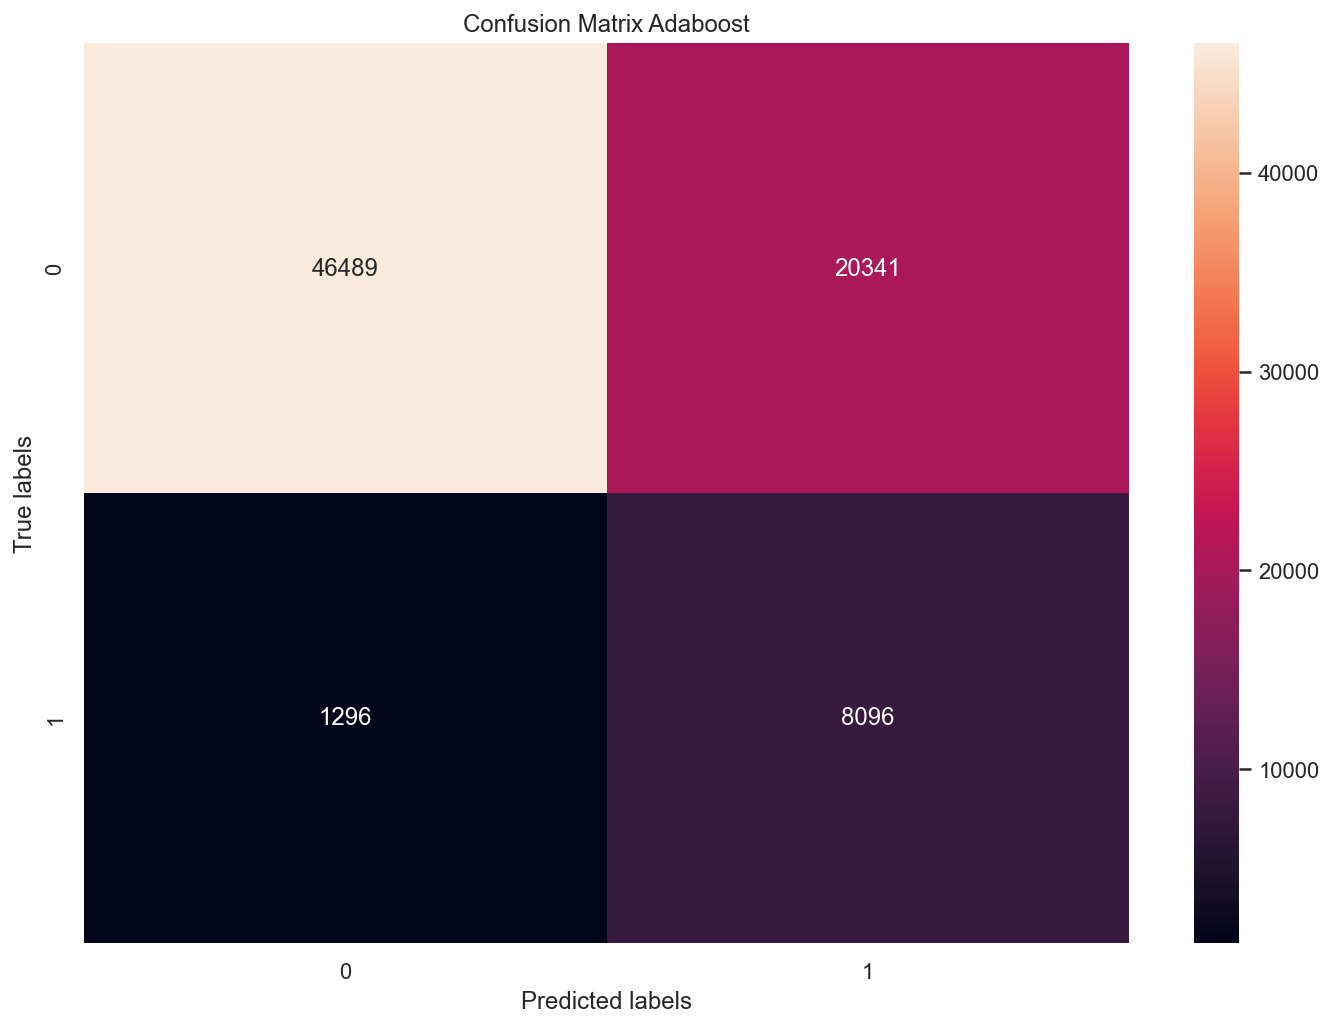

In [97]:
ax = plt.subplot()
sns.heatmap(cm_ada, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix Adaboost');
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);

The graph show 46489 class 0 predict true and 8096 class 1 predict true, we have about 0.45% class 0 predict wrong and 0.15% class 1 predict wrong, this model can predict class 1 better than decision tree but class 0 is not good.

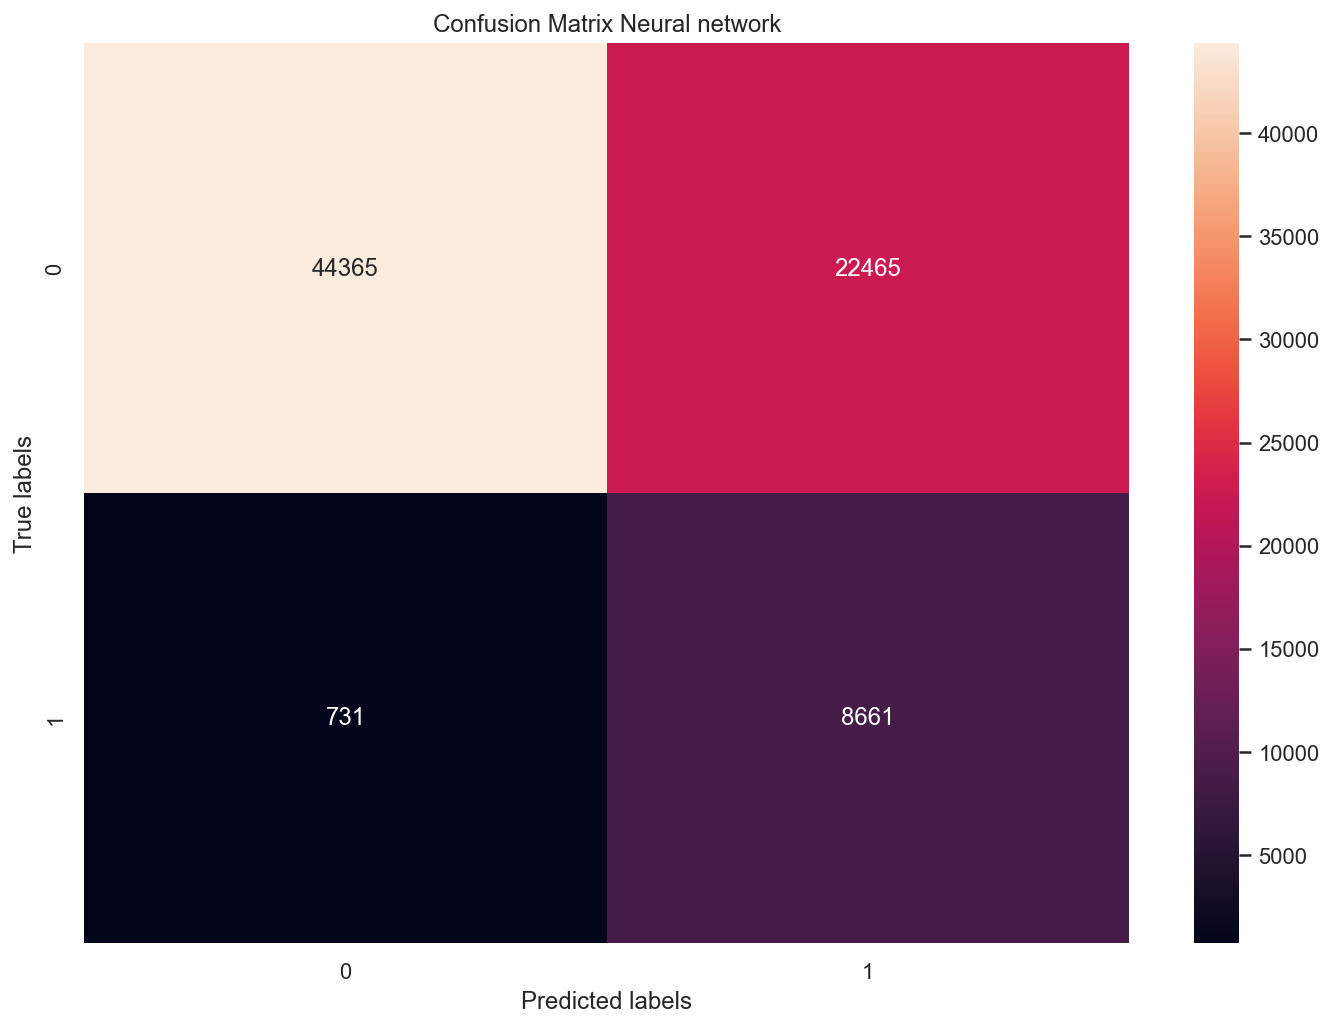

In [98]:
ax = plt.subplot()
sns.heatmap(cm_nn, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix Neural network');
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);

The graph show 44365 class 0 predict true and 8661 class 1 predict true, we have about 0.47% class 0 predict wrong and 0.12% class 1 predict wrong, we can see this model is best to classify class 1 but class 0 is not good.

=> In 5 models, for the balancing result we should use decision model to have better for both class 0 and 1.

### Report

In [99]:
print("Report model decision tree\n")
print(classification_report(linear_classifier_pred, y_val, target_names=target_names))

Report model decision tree

              precision    recall  f1-score   support

           0       0.59      0.99      0.74     39664
           1       0.98      0.25      0.40     36558

    accuracy                           0.64     76222
   macro avg       0.78      0.62      0.57     76222
weighted avg       0.78      0.64      0.58     76222



In [100]:
print("Report model random forest\n")
print(classification_report(forest_pred, y_val, target_names=target_names))

Report model random forest

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     67051
           1       0.34      0.34      0.34      9171

    accuracy                           0.84     76222
   macro avg       0.62      0.63      0.62     76222
weighted avg       0.84      0.84      0.84     76222



In [101]:
print("Report model decision tree\n")
print(classification_report(decisiontree_classifier_pred, y_val, target_names=target_names))

Report model decision tree

              precision    recall  f1-score   support

           0       0.74      0.96      0.83     51287
           1       0.78      0.29      0.43     24935

    accuracy                           0.74     76222
   macro avg       0.76      0.63      0.63     76222
weighted avg       0.75      0.74      0.70     76222



In [102]:
print("Report model Adaboost\n")
print(classification_report(ada_pred, y_val, target_names=target_names))

Report model Adaboost

              precision    recall  f1-score   support

           0       0.70      0.97      0.81     47785
           1       0.86      0.28      0.43     28437

    accuracy                           0.72     76222
   macro avg       0.78      0.63      0.62     76222
weighted avg       0.76      0.72      0.67     76222



In [103]:
print("Report model Neural network\n")
print(classification_report(nn_pred, y_val, target_names=target_names))

Report model Neural network

              precision    recall  f1-score   support

           0       0.66      0.98      0.79     45096
           1       0.92      0.28      0.43     31126

    accuracy                           0.70     76222
   macro avg       0.79      0.63      0.61     76222
weighted avg       0.77      0.70      0.64     76222



In [115]:
print("Report model Logistic Regression\n")
print(classification_report(log_pred, y_val, target_names=target_names))

Report model Logistic Regression

              precision    recall  f1-score   support

           0       0.59      0.99      0.74     39653
           1       0.98      0.25      0.40     36569

    accuracy                           0.64     76222
   macro avg       0.78      0.62      0.57     76222
weighted avg       0.78      0.64      0.58     76222



### Make Prediction Using Test Dataset 'test_df'

This section to classify test dataframe

We use 5 models to predict result on test data, then create 4 new columns for each result.

In [18]:
test_prediction_linear = linear_classifier.predict(X_test)
test_prediction_forest = forest_classifier.predict(X_test)
test_prediction_tree = decisiontree_classifier.predict(X_test)
test_prediction_ada = ada_classifier.predict(X_test)
test_prediction_nn = nn.predict(X_test)

NameError: name 'linear_classifier' is not defined

In [107]:
test_df_ori['Prediction_linear'] = test_prediction_linear
test_df_ori['Prediction_randomforest'] = test_prediction_forest
test_df_ori['Prediction_decisiontree'] = test_prediction_tree
test_df_ori['Prediction_adaboost'] = test_prediction_ada
test_df_ori['Prediction_neuralnetwork'] = test_prediction_nn

In [108]:
test_df_ori #show final results

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Prediction_linear,Prediction_randomforest,Prediction_decisiontree,Prediction_adaboost,Prediction_neuralnetwork
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53,0,0,0,0,0
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111,1,0,1,1,1
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199,1,0,1,1,1
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187,0,0,0,0,0
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,Female,26,1,37.0,1,< 1 Year,No,30867.0,152.0,56,0,0,0,0,0
127033,508143,Female,38,1,28.0,0,1-2 Year,Yes,28700.0,122.0,165,1,0,1,1,1
127034,508144,Male,21,1,46.0,1,< 1 Year,No,29802.0,152.0,74,0,0,0,0,0
127035,508145,Male,71,1,28.0,1,1-2 Year,No,62875.0,26.0,265,0,0,0,0,0


In [75]:
from sklearn.ensemble import RandomForestClassifier
forest_classifier = RandomForestClassifier(n_estimators=100,criterion='entropy')

forest_classifier.fit(X_train_res, y_train_res)

forest_pred = forest_classifier.predict(X_val)#predict validation data
cm_forest = confusion_matrix(y_val, forest_pred) #traditional confusion matrix

In [79]:
print(forest_pred)

[0 0 0 ... 0 0 0]


In [82]:
test_prediction_forest = forest_classifier.predict(X_test)

#test_df_ori = test_df.copy()
test_df_ori['Prediction_randomforest'] = test_prediction_forest

In [83]:
print(test_df_ori.head(5))
print(test_df_ori.columns)

       id Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0  381110   Male   25                1         11.0                   1   
1  381111   Male   40                1         28.0                   0   
2  381112   Male   47                1         28.0                   0   
3  381113   Male   24                1         27.0                   1   
4  381114   Male   27                1         28.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0    < 1 Year             No         35786.0                 152.0       53   
1    1-2 Year            Yes         33762.0                   7.0      111   
2    1-2 Year            Yes         40050.0                 124.0      199   
3    < 1 Year            Yes         37356.0                 152.0      187   
4    < 1 Year             No         59097.0                 152.0      297   

   Prediction_randomforest  
0                        0  
1               

In [84]:
print("Percentage Acceptance Rate of Cross-Sell Offer:")
accept = len(test_df_ori[test_df_ori['Prediction_randomforest']==1])
total = len(test_df_ori)
print(accept/total)

Percentage Acceptance Rate of Cross-Sell Offer:
0.15365602147405874


In [93]:
forest_pred_proba = forest_classifier.predict_proba(X_test)[::,1] #predict probabilities
print(forest_pred_proba)

[0.01 0.41 0.2  ... 0.01 0.01 0.08]


In [94]:
print(X_test.shape)

(127037, 10)


In [95]:
df_accept = test_df_ori[test_df_ori['Prediction_randomforest']==1]
test_df_ori['Prediction_RF_Prob'] = forest_pred_proba
df_accept = test_df_ori.sort_values('Prediction_RF_Prob', ascending=False)
df_accept = df_accept.head(63519)

In [97]:
print("Summary of Top 50% of Customers Who Accept Vehicle Insurance Offer")
print("Average Age:")
print(df_accept['Age'].mean())
print("Previously Insured:")
print(df_accept['Previously_Insured'].sum()/len(df_accept))
print("Annual Premium: ")
print(df_accept['Annual_Premium'].mean())
print("Vechicle Damage:")
print(df_accept['Vehicle_Damage'].mode())
print("Gender:")
print(df_accept['Gender'].mode())
print("Policy_Sales_Channel:")
print(df_accept['Policy_Sales_Channel'].mode())
print("Vehicle Age: ")
print(df_accept['Vehicle_Age'].mode())

Summary of Top 50% of Customers Who Accept Vehicle Insurance Offer
Average Age:
42.10285111541429
Previously Insured:
0.006439018246508919
Annual Premium: 
31004.826351170515
Vechicle Damage:
0    Yes
dtype: object
Gender:
0    Male
dtype: object
Policy_Sales_Channel:
0    26.0
dtype: float64
Vehicle Age: 
0    1-2 Year
dtype: object


## Cumulative Gains Chart
This chart will enable us to predict how many offers need to be sent out to the current customers who are likely to purchase vehicle insurance when cross-sold to.  We can then figure out the cost effectiveness of the model and communicate clearly to non-technical stakeholders the marketing campaign ROI on this project.

As you can see below, the curve reaches 100% at about 50% of the sample.  This means, that if we send out cross-selling offers for vehicle insurance to the top 50% of our customers who have been predicted by our model to most likely buy, we can expect to achieve 100% of the gains or acceptances for cross-sells.  

Keep in mind that with RandomForestClassifier, the standard cutoff is at 0.5 for classification.  So if a customer is predicted with 51% probability to purchase vehicle insurance in a cross-selling offer, they will be counted as likely to purchase with a value 1 instead of 0.  With several more iterations, we can adjust this classification cutoff to more accurately reflect the reality, but for now we use the standard cutoff for initial modeling purposes.

In terms of the business implications, what this means is that for a given number of customers who receive the offer, 15% will end up accepting.  To illustrate, given a set of 100,000 customers, the client's marketing department only needs to send out to 15,000 of those customers because those are the customers the model predicts are likely to purchase vehicle insurance.  And of those 15,000, we only need to send out to 7,500 to gain the full number of people who would signup anyway.

Give that the client customer base is 300,000, we can estimate to send out offers to 22,500 customers at a cost of $300 for the email marketing software costs.  Additional costs needs to be factored in to calculate the ROI, see below:

Assuming the cost of developing and implementing this prediction model will be around the budget of:
Duration: 3-4 months
Salaries: 250k (USD) for a Team of 5 consisting of 2 Data Scientists, 1 Business Intelligence Expert, 2 Marketers
Cost of Marketing Campaign: $300/month email marketing for 22,500 emails sent out
Return: 22,500 customers at minimum annual coverage price of 561 USD = 12.6M USD additional revenue per 300,000 customers

==> ROI = 12.6M USD/((250k USD salaries/month * 4 months) + 1200 USD email marketing software) ~~ <b>12x on initial investment</b>

That is an ROI of 12x for this project.  You risk approximately 1M USD, but you have a potential gain of 12.6M USD.

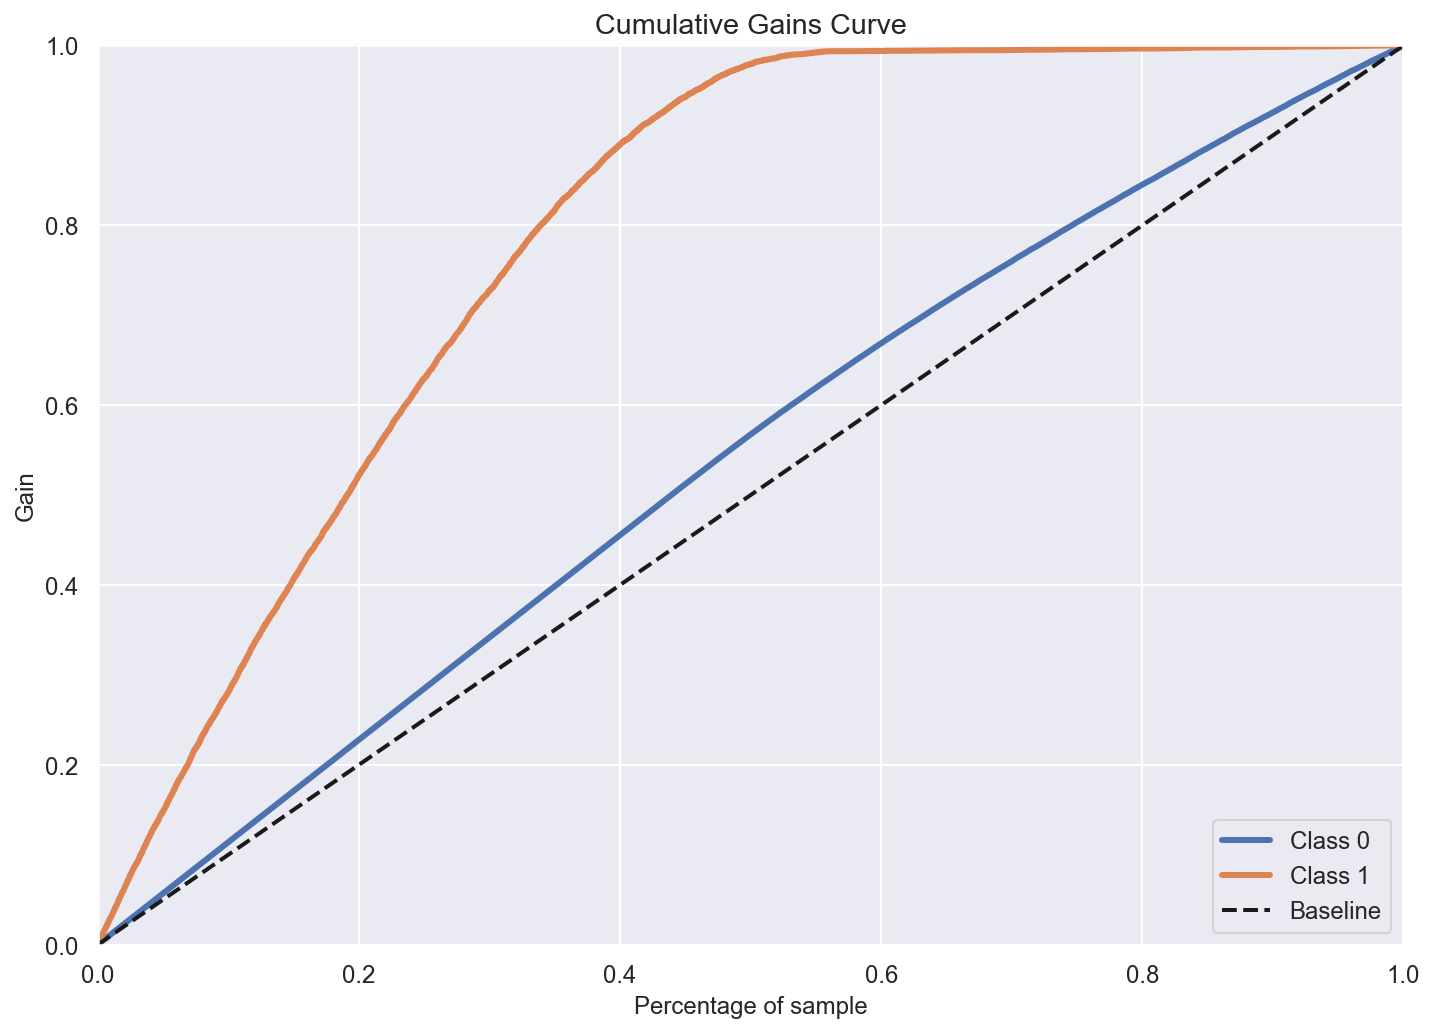

In [116]:
import scikitplot as skplt

forest_pred_proba = forest_classifier.predict_proba(X_val)
ax = skplt.metrics.plot_cumulative_gain(y_true = y_val, y_probas = forest_pred_proba)

# 7. Next Steps/Recommendation
Refer to Written Report

Next steps is to understand how the client can reach these cusomters beisdes just sending emails.We recommend using some social media apllications to reach the perspective audience.  We need to tailor the method based on the age groups that are being reached out to. Luckly everyone uses social media so that is a safe route to go to cross sell to customers fast. 